# Inerpretation-Net Training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes

config = {
    'data': {
        'd': 2, #degree
        'n': 5, #number of variables
        'monomial_vars': None, #int or None
        'laurent': False, #use Laurent polynomials (negative degree with up to -d)  
        'neg_d': 0,#int or None
        'neg_d_prob': 0,
        'sparsity': None,
        'sample_sparsity': 5,
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 1,
        'a_min': -1,
        'lambda_nets_total': 10000,
        'noise': 0,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'border_min': 0.2, #needs to be between 0 and (x_max-x_min)/2
        'border_max': 0.4,
        'lower_degree_prob': 0.5,
        'a_zero_prob': 0.25,
        'a_random_prob': 0.1,      
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
    },
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True,  #if early stopping is used, multi_epoch_analysis is deactivated
        'early_stopping_min_delta_lambda': 1e-4,
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sample_sparsity'],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'mae',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 5000,
    },
    'i_net': {
        'optimizer': 'custom',#adam
        'inet_loss': 'mae',
        'inet_metrics': ['r2'],
        'dropout': 0.25,
        'dropout_output': 0,
        'epochs': 500, 
        'early_stopping': True,
        'batch_size': 256,
        'dense_layers': [512, 1024],
        'convolution_layers': None,
        'lstm_layers': None,
        'interpretation_dataset_size': 10000,
                
        'interpretation_net_output_monomials': 5, #(None, int) #CONSTANT IS NOT INCLUDED
        'interpretation_net_output_shape': None, #calculated automatically later
        'test_size': 100, #Float for fraction, Int for number 0
        
        'normalize_inet_data': False,
        'inet_training_without_noise': False, #dataset size without noise hardcoded to 50k in generate_paths
        'sparse_poly_representation_version': 2, #(1, 2); 1=old, 2=new

        'evaluate_with_real_function': True, #False
        'consider_labels_training': True, #False
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        'nas': True,
        'nas_type': 'SEQUENTIAL', #options:(None, 'SEQUENTIAL', 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 50,
    },
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': True,
        'each_epochs_save_lambda': 100,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
        
        #set if samples analysis should be performed
        'samples_list': None,#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 
       
        'random_evaluation_dataset_size': 500,
        
        'symbolic_metamodeling_evaluation': False,
        'symbolic_metamodeling_poly_evaluation': False,
        'symbolic_metamodeling_function_evaluation': False,
        'symbolic_metamodeling_poly_function_evaluation': False,
        
        'symbolic_regression_evaluation': True,
        'per_network_evaluation': False,
    },
    'computation':{
        'n_jobs': 10,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}

## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import os
import shutil

import logging

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score

from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.utils import plot_model
from IPython.display import Image

import keras.backend as K
from livelossplot import PlotLossesKerasTF
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib import pyplot as plt
import seaborn as sns


import tensorflow as tf
import random 


import warnings


from IPython.display import display, Math, Latex, clear_output



In [4]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

multi_epoch_analysis = False if early_stopping_lambda else multi_epoch_analysis #deactivate multi_epoch_analysis if early stopping is used

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

data_reshape_version = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

logging.getLogger('tensorflow').disabled = True

sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

sys.path.append('..')

In [5]:
from utilities.utility_functions import flatten, rec_gen

list_of_monomial_identifiers_extended = []

if laurent:
    variable_sets = [list(flatten([[_d for _d in range(d+1)], [-_d for _d in range(1, neg_d+1)]])) for _ in range(n)]
    list_of_monomial_identifiers_extended = rec_gen(variable_sets)    
        
    print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
    #print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
    #print('Sparsity:' + str(sparsity))
    if len(list_of_monomial_identifiers_extended) < 500:
        print(list_of_monomial_identifiers_extended)        
else:
    variable_sets = [[_d for _d in range(d+1)] for _ in range(n)]  
    list_of_monomial_identifiers_extended = rec_gen(variable_sets)

    print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
    #print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
    #print('Sparsity: ' + str(sparsity))
    if len(list_of_monomial_identifiers_extended) < 500:
        print(list_of_monomial_identifiers_extended)    
list_of_monomial_identifiers = []
for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
    if np.sum(monomial_identifier) <= d:
        if monomial_vars == None or len(list(filter(lambda x: x != 0, monomial_identifier))) <= monomial_vars:
            list_of_monomial_identifiers.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers)))
#print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
#print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


List length: 243
[[0, 0, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 2], [0, 0, 0, 1, 0], [0, 0, 0, 1, 1], [0, 0, 0, 1, 2], [0, 0, 0, 2, 0], [0, 0, 0, 2, 1], [0, 0, 0, 2, 2], [0, 0, 1, 0, 0], [0, 0, 1, 0, 1], [0, 0, 1, 0, 2], [0, 0, 1, 1, 0], [0, 0, 1, 1, 1], [0, 0, 1, 1, 2], [0, 0, 1, 2, 0], [0, 0, 1, 2, 1], [0, 0, 1, 2, 2], [0, 0, 2, 0, 0], [0, 0, 2, 0, 1], [0, 0, 2, 0, 2], [0, 0, 2, 1, 0], [0, 0, 2, 1, 1], [0, 0, 2, 1, 2], [0, 0, 2, 2, 0], [0, 0, 2, 2, 1], [0, 0, 2, 2, 2], [0, 1, 0, 0, 0], [0, 1, 0, 0, 1], [0, 1, 0, 0, 2], [0, 1, 0, 1, 0], [0, 1, 0, 1, 1], [0, 1, 0, 1, 2], [0, 1, 0, 2, 0], [0, 1, 0, 2, 1], [0, 1, 0, 2, 2], [0, 1, 1, 0, 0], [0, 1, 1, 0, 1], [0, 1, 1, 0, 2], [0, 1, 1, 1, 0], [0, 1, 1, 1, 1], [0, 1, 1, 1, 2], [0, 1, 1, 2, 0], [0, 1, 1, 2, 1], [0, 1, 1, 2, 2], [0, 1, 2, 0, 0], [0, 1, 2, 0, 1], [0, 1, 2, 0, 2], [0, 1, 2, 1, 0], [0, 1, 2, 1, 1], [0, 1, 2, 1, 2], [0, 1, 2, 2, 0], [0, 1, 2, 2, 1], [0, 1, 2, 2, 2], [0, 2, 0, 0, 0], [0, 2, 0, 0, 1], [0, 2, 0, 0, 2], [0, 2, 0, 1, 

  0%|          | 0/243 [00:00<?, ?it/s]

List length: 21
[[0, 0, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 2], [0, 0, 0, 1, 0], [0, 0, 0, 1, 1], [0, 0, 0, 2, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 1], [0, 0, 1, 1, 0], [0, 0, 2, 0, 0], [0, 1, 0, 0, 0], [0, 1, 0, 0, 1], [0, 1, 0, 1, 0], [0, 1, 1, 0, 0], [0, 2, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 1], [1, 0, 0, 1, 0], [1, 0, 1, 0, 0], [1, 1, 0, 0, 0], [2, 0, 0, 0, 0]]


In [6]:
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['multi_epoch_analysis'] = multi_epoch_analysis
config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda
config['i_net']['data_reshape_version'] = data_reshape_version

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d']) if not laurent else len(list_of_monomial_identifiers)
config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']

config['i_net']['interpretation_net_output_shape'] = config['data']['sparsity'] if config['i_net']['interpretation_net_output_monomials'] is None else config['data']['sparsity']*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials'] if config['i_net']['sparse_poly_representation_version'] == 1 else config['data']['n']*(config['data']['d']+1)*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials']  
print('Output Shape: ', config['i_net']['interpretation_net_output_shape'])

transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sample_sparsity')*config['data']['sample_sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])



initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)
initialize_utility_functions_config_from_curent_notebook(config)
initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='interpretation_net'))
create_folders_inet()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

Output Shape:  80


In [7]:
print(path_identifier_interpretation_net_data)

print(path_identifier_lambda_net_data)


inet_dense512-1024-output_80_drop0.25e500b256_custom/lnets_10000_25-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_5_d_2_negd_0_prob_0_spars_5_amin_-1_amax_1_xdist_uniform_noise_normal_0bmin0.2bmax0.4lowd0.5azero0.25arand0.1
lnets_10000_25-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_5_d_2_negd_0_prob_0_spars_5_amin_-1_amax_1_xdist_uniform_noise_normal_0bmin0.2bmax0.4lowd0.5azero0.25arand0.1


In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Load Data and Generate Datasets

In [9]:
l1 = tf.constant([10,2,3,4,5,6,7,8,9,10,11,12])
print(l1)
l1_by_monomial = tf.transpose(tf.stack(tf.split(l1, 3)))
print(l1_by_monomial)
l1_by_monomial_by_var = tf.split(l1_by_monomial, 2, axis=0)
print(l1_by_monomial_by_var)
l1_by_monomial_by_var_new = []
for tensor in l1_by_monomial_by_var:
    l1_by_monomial_by_var_new.append(tf.transpose(tensor))
l1_by_monomial_by_var = l1_by_monomial_by_var_new   
print(l1_by_monomial_by_var)

indices = tf.argmax(l1_by_monomial_by_var, axis=2) 
print(indices)

tf.Tensor([10  2  3  4  5  6  7  8  9 10 11 12], shape=(12,), dtype=int32)
tf.Tensor(
[[10  5  9]
 [ 2  6 10]
 [ 3  7 11]
 [ 4  8 12]], shape=(4, 3), dtype=int32)
[<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[10,  5,  9],
       [ 2,  6, 10]], dtype=int32)>, <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[ 3,  7, 11],
       [ 4,  8, 12]], dtype=int32)>]
[<tf.Tensor: shape=(3, 2), dtype=int32, numpy=
array([[10,  2],
       [ 5,  6],
       [ 9, 10]], dtype=int32)>, <tf.Tensor: shape=(3, 2), dtype=int32, numpy=
array([[ 3,  4],
       [ 7,  8],
       [11, 12]], dtype=int32)>]
tf.Tensor(
[[0 1 1]
 [1 1 1]], shape=(2, 3), dtype=int64)


In [10]:
def load_lambda_nets(index, no_noise=False):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    path_identifier_lambda_net_data_loading = None 
                
    if no_noise==True:
        path_identifier_lambda_net_data_loading = generate_paths(path_type='interpretation_net_no_noise')['path_identifier_lambda_net_data']
    else:
        path_identifier_lambda_net_data_loading = path_identifier_lambda_net_data 
        
    directory = './data/weights/' + 'weights_' + path_identifier_lambda_net_data_loading + '/'
    path_weights = directory + 'weights_epoch_' + str(index).zfill(3) + '.txt'
    path_X_data = directory + 'lambda_X_test_data.txt'
    path_y_data = directory + 'lambda_y_test_data.txt'        
    
    weight_data = pd.read_csv(path_weights, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        weight_data = weight_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_X_test_data = pd.read_csv(path_X_data, sep=",", header=None)
    lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_y_test_data = pd.read_csv(path_y_data, sep=",", header=None)
    lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
        
    lambda_nets = [None] * weight_data.shape[0]
    for i, (row_weights, row_lambda_X_test_data, row_lambda_y_test_data) in enumerate(zip(weight_data.values, lambda_X_test_data.values, lambda_y_test_data.values)):        
        lambda_net = LambdaNet(row_weights, row_lambda_X_test_data, row_lambda_y_test_data)
        lambda_nets[i] = lambda_net
                
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [11]:
#LOAD DATA
if inet_training_without_noise:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list_without_noise = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1, no_noise=True) for i in epochs_save_range_lambda)  
    del parallel
    
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
    del parallel
else:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
    del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=10)]: Using backend MultiprocessingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   41.1s finished


## Data Inspection

In [12]:
lambda_net_dataset.as_pandas().head()

seed  00000-target  00001-target  00002-target  00010-target  \
6252  1373158606         0.000         0.000         0.000         0.000   
4684  1373158606         0.215         0.000         0.000         0.000   
1731  1373158606         0.000         0.000         0.480         0.479   
4742  1373158606         0.000         0.000         0.133         0.000   
4521  1373158606         0.000         0.003         0.000         0.000   

      00011-target  00020-target  00100-target  00101-target  00110-target  \
6252         0.000         0.000         0.000         0.135         0.000   
4684         0.000         0.000         0.000         0.000         0.000   
1731         0.000         0.000         0.000         0.000         0.000   
4742         0.905        -0.360         0.000         0.000         0.000   
4521        -0.949         0.000         0.000         0.000         0.000   

      00200-target  01000-target  01001-target  01010-target  01100-target  \
6252         0.278         0.000        -0.016         0.000         0.000   
4684         0.276         0.000         0.000         0.000        -0.446   
1731         0.000         0.000         0.000         0.000        -0.350   
4742         0.089         0.000         0.000         0.000         0.000   
4521         0.000        -0.281         0.000         0.000         0.000   

      02000-target  10000-target  10001-target  10010-target  10100-target  \
6252         0.000         0.000         0.000         0.000         0.705   
4684        -0.313        -0.867         0.000         0.000         0.000   
1731         0.793         0.000         0.000         0.000        -0.642   
4742         0.000         0.000         0.000         0.000         0.000   
4521         0.000         0.000         0.000        -0.529         0.000   

      11000-target  20000-target  00000-lstsq_lambda  00001-lstsq_lambda  \
6252         0.838         0.000              -0.029               0.015   
4684         0.000         0.000               0.210               0.009   
1731         0.000         0.000               0.006               0.030   
4742         0.000        -0.173              -0.035               0.060   
4521         0.000        -0.378               0.020              -0.009   

      00002-lstsq_lambda  00010-lstsq_lambda  00011-lstsq_lambda  \
6252              -0.011               0.019               0.005   
4684              -0.006              -0.014              -0.003   
1731               0.448               0.465               0.000   
4742               0.103               0.034               0.861   
4521               0.002              -0.041              -0.899   

      00020-lstsq_lambda  00100-lstsq_lambda  00101-lstsq_lambda  \
6252              -0.016               0.045               0.125   
4684               0.009               0.010              -0.001   
1731              -0.008               0.003              -0.004   
4742              -0.369               0.032               0.005   
4521               0.010              -0.027              -0.004   

      00110-lstsq_lambda  00200-lstsq_lambda  01000-lstsq_lambda  \
6252              -0.003               0.258               0.024   
4684               0.004               0.257               0.007   
1731               0.013              -0.020               0.054   
4742              -0.014               0.063               0.027   
4521               0.000               0.018              -0.281   

      01001-lstsq_lambda  01010-lstsq_lambda  01100-lstsq_lambda  \
6252              -0.022              -0.006              -0.002   
4684               0.003               0.005              -0.426   
1731               0.005               0.012              -0.380   
4742              -0.005               0.000              -0.009   
4521              -0.010               0.005               0.009   

      02000-lstsq_lambda  10000-lstsq_lambda  10001-lst

In [13]:
lambda_net_dataset.as_pandas().describe()

seed  00000-target  00001-target  00002-target  00010-target  \
count      10000.000     10000.000     10000.000     10000.000     10000.000   
mean  1373158606.000         0.004         0.001        -0.003         0.001   
std            0.000         0.276         0.283         0.284         0.282   
min   1373158606.000        -1.000        -0.999        -1.000        -0.999   
25%   1373158606.000         0.000         0.000         0.000         0.000   
50%   1373158606.000         0.000         0.000         0.000         0.000   
75%   1373158606.000         0.000         0.000         0.000         0.000   
max   1373158606.000         0.999         0.998         0.999         1.000   

       00011-target  00020-target  00100-target  00101-target  00110-target  \
count     10000.000     10000.000     10000.000     10000.000     10000.000   
mean         -0.004         0.003         0.001        -0.001         0.005   
std           0.281         0.274         0.279         0.281         0.277   
min          -0.999        -0.999        -0.999        -0.998        -0.999   
25%           0.000         0.000         0.000         0.000         0.000   
50%           0.000         0.000         0.000         0.000         0.000   
75%           0.000         0.000         0.000         0.000         0.000   
max           1.000         1.000         0.999         1.000         1.000   

       00200-target  01000-target  01001-target  01010-target  01100-target  \
count     10000.000     10000.000     10000.000     10000.000     10000.000   
mean          0.003         0.001        -0.004         0.001        -0.002   
std           0.291         0.276         0.286         0.279         0.280   
min          -0.999        -1.000        -0.998        -1.000        -0.997   
25%           0.000         0.000         0.000         0.000         0.000   
50%           0.000         0.000         0.000         0.000         0.000   
75%           0.000         0.000         0.000         0.000         0.000   
max           0.999         1.000         0.998         1.000         0.999   

       02000-target  10000-target  10001-target  10010-target  10100-target  \
count     10000.000     10000.000     10000.000     10000.000     10000.000   
mean          0.001         0.002         0.004        -0.002         0.002   
std           0.284         0.285         0.278         0.290         0.283   
min          -1.000        -0.999        -0.998        -1.000        -1.000   
25%           0.000         0.000         0.000         0.000         0.000   
50%           0.000         0.000         0.000         0.000         0.000   
75%           0.000         0.000         0.000         0.000         0.000   
max           1.000         1.000         1.000         1.000         1.000   

       11000-target  20000-target  00000-lstsq_lambda  00001-lstsq_lambda  \
count     10000.000     10000.000           10000.000           10000.000   
mean          0.001         0.001              -0.006               0.011   
std           0.283         0.279               0.273               0.288   
min          -1.000        -1.000              -1.052              -1.105   
25%           0.000         0.000              -0.031              -0.018   
50%           0.000         0.000              -0.004               0.003   
75%           0.000         0.000               0.014               0.037   
max           1.000         1.000               1.006               1.411   

       00002-lstsq_lambda  00010-lstsq_lambda  00011-lstsq_lambda  \
count           10000.000           10000.000           10000.000   
mean               -0.012               0.014              -0.004   
std                 0.271               0.288               0.266   
min                -0.995              -1.057              -0.985   
25%                -0.020              -0.018              -0.009   
50%                -0.004               0.006      

In [14]:
lambda_net_dataset.X_test_data_list[0][:10]

array([[0.61953536, 0.9741457 , 0.46680659, 0.49776036, 0.86019679],
       [0.72910667, 0.61094799, 0.92371269, 0.08555449, 0.07980001],
       [0.81699541, 0.46397194, 0.19362828, 0.24013508, 0.33092769],
       [0.86053752, 0.33458561, 0.41499257, 0.28032716, 0.6508531 ],
       [0.3949162 , 0.74394349, 0.86208017, 0.9772995 , 0.57861012],
       [0.43701616, 0.5057832 , 0.07975839, 0.30121402, 0.94739198],
       [0.26152861, 0.51987584, 0.75460088, 0.61431661, 0.19476404],
       [0.35163938, 0.20872544, 0.14158339, 0.43655386, 0.40572667],
       [0.65534944, 0.36340559, 0.8659874 , 0.14811638, 0.87008502],
       [0.3979848 , 0.75216565, 0.32811658, 0.64674227, 0.5343556 ]])

In [15]:
lambda_net_dataset.y_test_data_list[0][:10]

array([[0.81114727],
       [1.09404528],
       [0.44582668],
       [0.57382601],
       [0.7530337 ],
       [0.21425484],
       [0.42936283],
       [0.10858684],
       [0.90446246],
       [0.39015335]])

## Generate Datasets for Interpretation-Net training

In [16]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []


if inet_training_without_noise:
   
    for lambda_net_dataset, lambda_net_dataset_without_noise in zip(lambda_net_dataset_list, lambda_net_dataset_list_without_noise):
        if inet_holdout_seed_evaluation:
            raise SystemExit('Holdout Evaluation not implemented with inet training without noise')
            
        else:
            lambda_net_train_dataset = lambda_net_dataset_without_noise

            lambda_net_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset, lambda_net_dataset_list_without_noise
        
else:

    for lambda_net_dataset in lambda_net_dataset_list:

        if inet_holdout_seed_evaluation:

            complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

            random.seed(RANDOM_SEED)

            if isinstance(test_size, float):
                test_size = int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-test_size)))

            test_seeds = random.sample(complete_seed_list, test_size)
            lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
            complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)

            random.seed(RANDOM_SEED)
            valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-0.1))))
            lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
            complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

            train_seeds = complete_seed_list
            lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset
        else:

            lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)
            lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset, lambda_net_train_with_valid_dataset


del lambda_net_dataset_list

In [17]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(8910, 240)

In [18]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(990, 240)

In [19]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(100, 240)

In [20]:
lambda_net_train_dataset_list[-1].as_pandas().head()

seed  00000-target  00001-target  00002-target  00010-target  \
5548  1373158606         0.000         0.000         0.255         0.000   
1854  1373158606         0.000         0.000        -0.016         0.000   
739   1373158606         0.218         0.000         0.979        -0.272   
3588  1373158606         0.000         0.000        -0.493         0.000   
4649  1373158606         0.388         0.000         0.573         0.000   

      00011-target  00020-target  00100-target  00101-target  00110-target  \
5548         0.000        -0.493         0.000         0.000         0.050   
1854         0.000         0.472         0.561         0.000         0.000   
739          0.696         0.000         0.000         0.000         0.000   
3588         0.000         0.000         0.000         0.000         0.110   
4649         0.677         0.000         0.895         0.000         0.000   

      00200-target  01000-target  01001-target  01010-target  01100-target  \
5548         0.000         0.000         0.000         0.000         0.000   
1854         0.000         0.000         0.000         0.000         0.000   
739          0.000         0.000         0.000         0.000         0.000   
3588        -0.701         0.000         0.000         0.000         0.000   
4649         0.000         0.000         0.000         0.000         0.000   

      02000-target  10000-target  10001-target  10010-target  10100-target  \
5548         0.000         0.000        -0.102         0.000         0.000   
1854         0.000         0.000        -0.826         0.907         0.000   
739         -0.814         0.000         0.000         0.000         0.000   
3588         0.000         0.000        -0.432         0.000         0.000   
4649         0.000         0.000         0.000         0.000         0.714   

      11000-target  20000-target  00000-lstsq_lambda  00001-lstsq_lambda  \
5548         0.000        -0.779               0.007               0.005   
1854         0.000         0.000              -0.010               0.008   
739          0.000         0.000               0.148               0.162   
3588         0.492         0.000               0.005              -0.026   
4649         0.000         0.000               0.307               0.129   

      00002-lstsq_lambda  00010-lstsq_lambda  00011-lstsq_lambda  \
5548               0.244              -0.011               0.006   
1854              -0.053               0.043               0.039   
739                0.871              -0.178               0.607   
3588              -0.472               0.011               0.005   
4649               0.495               0.091               0.610   

      00020-lstsq_lambda  00100-lstsq_lambda  00101-lstsq_lambda  \
5548              -0.485               0.004               0.001   
1854               0.433               0.552              -0.026   
739               -0.023               0.033              -0.008   
3588              -0.012               0.008              -0.009   
4649              -0.039               0.941              -0.009   

      00110-lstsq_lambda  00200-lstsq_lambda  01000-lstsq_lambda  \
5548               0.048              -0.007              -0.007   
1854               0.016               0.012               0.008   
739               -0.030              -0.014               0.033   
3588               0.103              -0.697              -0.001   
4649              -0.020              -0.021               0.036   

      01001-lstsq_lambda  01010-lstsq_lambda  01100-lstsq_lambda  \
5548              -0.004               0.002               0.001   
1854              -0.015               0.009              -0.007   
739               -0.014              -0.021              -0.005   
3588              -0.007               0.005               0.005   
4649              -0.012              -0.005               0.001   

      02000-lstsq_lambda  10000-lstsq_lambda  10001-lst

In [21]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

seed  00000-target  00001-target  00002-target  00010-target  \
4197  1373158606         0.000         0.000        -0.432         0.000   
5318  1373158606         0.000         0.770         0.000         0.000   
3815  1373158606        -0.563         0.000         0.000         0.158   
9727  1373158606         0.000         0.000         0.000         0.000   
5410  1373158606         0.000         0.991         0.000         0.000   

      00011-target  00020-target  00100-target  00101-target  00110-target  \
4197         0.000         0.000         0.000         0.952         0.000   
5318        -0.280         0.000        -0.654         0.000         0.000   
3815         0.000         0.000         0.000         0.256         0.000   
9727         0.027         0.000         0.899         0.000         0.000   
5410         0.000         0.000         0.000         0.000         0.000   

      00200-target  01000-target  01001-target  01010-target  01100-target  \
4197         0.000         0.674         0.000         0.000         0.000   
5318         0.000         0.000         0.000         0.935         0.000   
3815         0.000         0.764         0.000         0.000         0.000   
9727        -0.898         0.000         0.000         0.000         0.000   
5410         0.554         0.000         0.000         0.000         0.000   

      02000-target  10000-target  10001-target  10010-target  10100-target  \
4197        -0.603        -0.575         0.000         0.000         0.000   
5318         0.000         0.000         0.000         0.000         0.000   
3815         0.000         0.000         0.000         0.000         0.000   
9727         0.000        -0.506         0.000         0.000         0.000   
5410         0.000         0.000         0.000         0.000        -0.170   

      11000-target  20000-target  00000-lstsq_lambda  00001-lstsq_lambda  \
4197         0.000         0.000              -0.012              -0.004   
5318         0.682         0.000              -0.084               0.758   
3815        -0.833         0.000              -0.562              -0.004   
9727         0.000         0.747              -0.005               0.012   
5410        -0.952         0.655              -0.000               0.989   

      00002-lstsq_lambda  00010-lstsq_lambda  00011-lstsq_lambda  \
4197              -0.414               0.019               0.004   
5318              -0.005               0.102              -0.260   
3815               0.002               0.156               0.009   
9727               0.002               0.009               0.022   
5410               0.005              -0.012               0.011   

      00020-lstsq_lambda  00100-lstsq_lambda  00101-lstsq_lambda  \
4197              -0.009               0.047               0.898   
5318              -0.052              -0.592               0.000   
3815              -0.001              -0.002               0.238   
9727              -0.015               0.891              -0.003   
5410               0.004               0.009               0.004   

      00110-lstsq_lambda  00200-lstsq_lambda  01000-lstsq_lambda  \
4197              -0.026              -0.001               0.640   
5318              -0.008              -0.031               0.102   
3815               0.011               0.007               0.773   
9727               0.011              -0.894               0.004   
5410               0.002               0.527               0.001   

      01001-lstsq_lambda  01010-lstsq_lambda  01100-lstsq_lambda  \
4197               0.013               0.009              -0.006   
5318               0.011               0.860               0.001   
3815               0.011              -0.015              -0.011   
9727              -0.010               0.007               0.003   
5410              -0.008              -0.012              -0.004   

      02000-lstsq_lambda  10000-lstsq_lambda  10001-lst

In [22]:
lambda_net_test_dataset_list[-1].as_pandas().head()

seed  00000-target  00001-target  00002-target  00010-target  \
7217  1373158606         0.000         0.000         0.000         0.000   
8291  1373158606         0.000         0.000        -0.541        -0.823   
4607  1373158606        -0.775         0.513         0.000         0.000   
5114  1373158606         0.889         0.000         0.000         0.000   
1859  1373158606         0.000         0.000         0.000         0.000   

      00011-target  00020-target  00100-target  00101-target  00110-target  \
7217         0.000        -0.275         0.000         0.000        -0.795   
8291        -0.882         0.000         0.000         0.000         0.000   
4607         0.000         0.000         0.000        -0.778         0.000   
5114         0.000         0.000         0.038         0.000         0.000   
1859         0.390         0.000         0.000         0.000        -0.950   

      00200-target  01000-target  01001-target  01010-target  01100-target  \
7217         0.333         0.000         0.000         0.000         0.000   
8291         0.000         0.000         0.000         0.000         0.000   
4607         0.000         0.000        -0.296         0.000         0.000   
5114         0.000         0.000        -0.707         0.000         0.000   
1859         0.000         0.930         0.000         0.000         0.000   

      02000-target  10000-target  10001-target  10010-target  10100-target  \
7217         0.000         0.640         0.053         0.000         0.000   
8291         0.000        -0.272         0.000        -0.335         0.000   
4607         0.000         0.000         0.000         0.000         0.977   
5114         0.351         0.000         0.396         0.000         0.000   
1859         0.457         0.000         0.000         0.000         0.000   

      11000-target  20000-target  00000-lstsq_lambda  00001-lstsq_lambda  \
7217         0.000         0.000               0.005              -0.009   
8291         0.000         0.000               0.021              -0.032   
4607         0.000         0.000              -0.766               0.460   
5114         0.000         0.000               0.877               0.022   
1859        -0.755         0.000               0.026              -0.014   

      00002-lstsq_lambda  00010-lstsq_lambda  00011-lstsq_lambda  \
7217               0.003              -0.010               0.014   
8291              -0.509              -0.844              -0.859   
4607               0.016              -0.020               0.012   
5114              -0.029               0.009              -0.012   
1859              -0.014              -0.010               0.396   

      00020-lstsq_lambda  00100-lstsq_lambda  00101-lstsq_lambda  \
7217              -0.289               0.006              -0.002   
8291               0.003              -0.016               0.003   
4607               0.013               0.016              -0.743   
5114              -0.016               0.047               0.014   
1859              -0.010              -0.016               0.021   

      00110-lstsq_lambda  00200-lstsq_lambda  01000-lstsq_lambda  \
7217              -0.755               0.300               0.015   
8291               0.013               0.002              -0.012   
4607              -0.007               0.002              -0.021   
5114               0.012              -0.012               0.028   
1859              -0.923              -0.018               0.942   

      01001-lstsq_lambda  01010-lstsq_lambda  01100-lstsq_lambda  \
7217               0.001              -0.015               0.008   
8291              -0.000              -0.013               0.004   
4607              -0.259               0.006              -0.004   
5114              -0.654              -0.004              -0.015   
1859               0.017              -0.009               0.007   

      02000-lstsq_lambda  10000-lstsq_lambda  10001-lst

## Interpretation Network Training

In [23]:
#%load_ext autoreload

In [24]:
#%autoreload 2
(history_list, 

#scores_valid_list,
scores_test_list, 

#function_values_valid_list, 
function_values_test_list, 

#polynomial_dict_valid_list,
polynomial_dict_test_list,

#distrib_dict_valid_list,
distrib_dict_test_list,

model_list) = calculate_interpretation_net_results(lambda_net_train_dataset_list, 
                                                   lambda_net_valid_dataset_list, 
                                                   lambda_net_test_dataset_list)

Trial 50 Complete [00h 07m 32s]
val_loss: 30.10585594177246

Best val_loss So Far: 10.965937614440918
Total elapsed time: 00h 32m 43s
Training Time: 24:32:58
---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------ LOADING MODELS -----------------------------------------------------
Loading Time: 0:00:02
---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------- PREDICT INET ------------------------------------------------------
Predict Time: 0:00:00
---------------------------------------------------------------------------------------------------------------------------
----------------------------------------- CALCULATE SYMBOLIC REGRESSION FUNCTION ------------------------------------------


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:  2.4min
[Parallel(n_jobs=10)]: Done   2 tasks      | elapsed:  2.5min
[Parallel(n_jobs=10)]: Done   3 tasks      | elapsed:  2.6min
[Parallel(n_jobs=10)]: Done   4 tasks      | elapsed:  2.6min
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:  2.6min
[Parallel(n_jobs=10)]: Done   6 tasks      | elapsed:  2.6min
[Parallel(n_jobs=10)]: Done   7 tasks      | elapsed:  2.6min
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:  2.6min
[Parallel(n_jobs=10)]: Done   9 tasks      | elapsed:  2.7min
[Parallel(n_jobs=10)]: Done  10 tasks      | elapsed:  2.8min
[Parallel(n_jobs=10)]: Done  11 tasks      | elapsed:  4.8min
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:  4.9min
[Parallel(n_jobs=10)]: Done  13 tasks      | elapsed:  4.9min
[Parallel(n_jobs=10)]: Done  14 tasks      | elapsed:  4.9min
[Parallel(n_jobs=10)]: Done  15 tasks      | elapsed:  

Symbolic Regression Optimization Time: 0:25:56
---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------ CALCULATE FUNCTION VALUES ------------------------------------------------
True


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.6s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  27 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  81 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


True
True


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


False


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


metamodel_poly
Exit <class 'KeyError'>
metamodel_functions
Exit <class 'KeyError'>
metamodel_functions_no_GD
Exit <class 'KeyError'>
symbolic_regression_functions


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    2.1s finished


[[ 2.83078870e-02  1.30963995e-01  1.38547987e-01 ...  2.16403784e-01
   4.70437078e-01  2.91546081e-02]
 [-4.07532417e-01 -5.18243109e-01 -4.57366823e-01 ... -8.35632536e-01
  -1.66457552e+00 -2.94231549e-01]
 [-5.60000000e-01 -5.60000000e-01 -5.60000000e-01 ... -5.60000000e-01
  -5.60000000e-01 -5.60000000e-01]
 ...
 [-2.02000000e-01 -2.02000000e-01 -2.02000000e-01 ... -2.02000000e-01
  -2.02000000e-01 -2.02000000e-01]
 [ 5.49655056e-01  1.39044559e+00  2.88594836e-01 ...  6.60618067e-01
   4.85825348e-01  9.94126514e-01]
 [-7.30117857e-02  3.77005778e-01  2.51126738e-02 ... -1.65692577e-03
   9.00274285e-02  5.57216022e-02]]
[0.54965506 1.39044559 0.28859484 ... 0.66061807 0.48582535 0.99412651]
[0.54965506 1.39044559 0.28859484 ... 0.66061807 0.48582535 0.99412651]
per_network_polynomials
Exit <class 'KeyError'>
FV Calculation Time: 0:00:21
---------------------------------------------------------------------------------------------------------------------------
-------------------

In [25]:
tf.keras.losses.categorical_crossentropy(tf.constant([1, 0, 0]), tf.constant([0.387872368, 0.348615289, 0.263512373]))


<tf.Tensor: shape=(), dtype=float32, numpy=0.94707894>

In [26]:
tf.keras.losses.categorical_crossentropy(tf.constant([[[1,0,0],[1,0,0],[1,0,0],[1,0,0],[1,0,0]],
                                                      [[1,0,0],[1,0,0],[1,0,0],[1,0,0],[1,0,0]],
                                                     [[1,0,0],[1,0,0],[1,0,0],[1,0,0],[1,0,0]],
                                                     [[1,0,0],[1,0,0],[1,0,0],[1,0,0],[1,0,0]],
                                                     [[1,0,0],[1,0,0],[1,0,0],[1,0,0],[1,0,0]]]), 
                                         tf.constant([[[0.387872368, 0.348615289, 0.263512373], [0.388814658, 0.329594404, 0.281590939],[0.388814658, 0.329594404, 0.281590939],[0.388814658, 0.329594404, 0.281590939],[0.388814658, 0.329594404, 0.281590939]],
                                                     [[0.388814658, 0.329594404, 0.281590939], [0.388814658, 0.329594404, 0.281590939],[0.388814658, 0.329594404, 0.281590939],[0.388814658, 0.329594404, 0.281590939],[0.388814658, 0.329594404, 0.281590939]],
                                                     [[0.388814658, 0.329594404, 0.281590939], [0.388814658, 0.329594404, 0.281590939],[0.388814658, 0.329594404, 0.281590939],[0.388814658, 0.329594404, 0.281590939],[0.388814658, 0.329594404, 0.281590939]],
                                                     [[0.388814658, 0.329594404, 0.281590939], [0.388814658, 0.329594404, 0.281590939],[0.388814658, 0.329594404, 0.281590939],[0.388814658, 0.329594404, 0.281590939],[0.388814658, 0.329594404, 0.281590939]],
                                                     [[0.388814658, 0.329594404, 0.281590939], [0.388814658, 0.329594404, 0.281590939],[0.388814658, 0.329594404, 0.281590939],[0.388814658, 0.329594404, 0.281590939],[0.388814658, 0.329594404, 0.281590939]]]))

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0.94707894, 0.9446525 , 0.9446525 , 0.9446525 , 0.9446525 ],
       [0.9446525 , 0.9446525 , 0.9446525 , 0.9446525 , 0.9446525 ],
       [0.9446525 , 0.9446525 , 0.9446525 , 0.9446525 , 0.9446525 ],
       [0.9446525 , 0.9446525 , 0.9446525 , 0.9446525 , 0.9446525 ],
       [0.9446525 , 0.9446525 , 0.9446525 , 0.9446525 , 0.9446525 ]],
      dtype=float32)>

## Evaluate Interpretation Net

In [27]:
polynomial_true_monomial_list = tf.constant([0,2,2,1,2,1])

In [28]:
polynomial_true_monomial_list = tf.map_fn(fn=lambda x: tf.sparse.to_dense(tf.SparseTensor([[x]], [1], [d+1])), elems=polynomial_true_monomial_list, fn_output_signature=tf.TensorSpec([d+1], dtype=tf.int32))
polynomial_true_monomial_list




<tf.Tensor: shape=(6, 3), dtype=int32, numpy=
array([[1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0]], dtype=int32)>

In [29]:
t1=tf.sparse.to_dense(tf.SparseTensor([[1]], [1], [d+1]))
t1

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([0, 1, 0], dtype=int32)>

In [30]:
polynomial_dict_test_list[-1].keys()

dict_keys(['lstsq_lambda_pred_polynomials', 'lstsq_target_polynomials', 'target_polynomials', 'inet_polynomials', 'symbolic_regression_functions'])

In [31]:
#11.273974418640137

In [32]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: False
dense_block_1/num_layers: 1
dense_block_1/units_0: 1024
dense_block_1/dropout: 0.5
dense_block_1/units_1: 32
optimizer: sgd
learning_rate: 0.1
Score: 10.965937614440918
None
Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: False
dense_block_1/num_layers: 1
dense_block_1/units_0: 1024
dense_block_1/dropout: 0.5
dense_block_1/units_1: 64
optimizer: adam_weight_decay
learning_rate: 0.001
dense_block_1/units_2: 64
Score: 10.966033935546875
None
Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: False
dense_block_1/num_layers: 1
dense_block_1/units_0: 1024
dense_block_1/dropout: 0.25
dense_block_1/units_1: 128
optimizer: sgd
learning_rate: 0.1
dense_block_1/units_2: 16
Score: 11.007060050964355
None
Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: False
dense_block_1/num_layers: 1
dense_block_1/units_0: 1024
dense_block_1/dropout: 0.25
dense_block_1/units_1: 128
optimizer: adam_weight_decay
lear

In [33]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 176)]        0                                            
__________________________________________________________________________________________________
cast_to_float32 (CastToFloat32) (None, 176)          0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 1024)         181248      cast_to_float32[0][0]            
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 1024)         0           dense[0][0]                      
______________________________________________________________________________________________

In [34]:
if evaluate_with_real_function:
    keys = ['inetPoly_VS_targetPoly_test', 'perNetworkPoly_VS_targetPoly_test', 'predLambda_VS_targetPoly_test', 'lstsqLambda_VS_targetPoly_test', 'lstsqTarget_VS_targetPoly_test']
else:
    keys = ['inetPoly_VS_predLambda_test', 'inetPoly_VS_lstsqLambda_test', 'perNetworkPoly_VS_predLambda_test', 'perNetworkPoly_VS_lstsqLambda_test', 'lstsqLambda_VS_predLambda_test', 'predLambda_VS_targetPoly_test']

In [35]:
scores_test_list[-1]

MAE  RMSE    MAPE  \
lambda_preds_VS_target_polynomials                   NaN   NaN     NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials        NaN   NaN     NaN   
lambda_preds_VS_lstsq_target_polynomials             NaN   NaN     NaN   
lambda_preds_VS_inet_polynomials                     NaN   NaN     NaN   
lambda_preds_VS_symbolic_regression_functions        NaN   NaN     NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.018 0.028   1.277   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000   0.000   
target_polynomials_VS_inet_polynomials             0.386 0.494  28.212   
target_polynomials_VS_symbolic_regression_funct...   NaN   NaN     NaN   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.018 0.028   3.342   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.389 0.497 100.109   
lstsq_lambda_pred_polynomials_VS_symbolic_regre...   NaN   NaN     NaN   
lstsq_target_polynomials_VS_inet_polynomials       0.386 0.494  28.212   
lstsq_target_polynomials_VS_symbolic_regression...   NaN   NaN     NaN   
inet_polynomials_VS_symbolic_regression_functions    NaN   NaN     NaN   

                                                    Accuracy  \
lambda_preds_VS_target_polynomials                       NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials            NaN   
lambda_preds_VS_lstsq_target_polynomials                 NaN   
lambda_preds_VS_inet_polynomials                         NaN   
lambda_preds_VS_symbolic_regression_functions            NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom...     0.899   
target_polynomials_VS_lstsq_target_polynomials         1.000   
target_polynomials_VS_inet_polynomials                 0.108   
target_polynomials_VS_symbolic_regression_funct...       NaN   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...     0.899   
lstsq_lambda_pred_polynomials_VS_inet_polynomials      0.104   
lstsq_lambda_pred_polynomials_VS_symbolic_regre...       NaN   
lstsq_target_polynomials_VS_inet_polynomials           0.108   
lstsq_target_polynomials_VS_symbolic_regression...       NaN   
inet_polynomials_VS_symbolic_regression_functions        NaN   

                                                    Accuracy Multilabel  \
lambda_preds_VS_target_polynomials                                  NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials                       NaN   
lambda_preds_VS_lstsq_target_polynomials                            NaN   
lambda_preds_VS_inet_polynomials                                    NaN   
lambda_preds_VS_symbolic_regression_functions                       NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom...                0.220   
target_polynomials_VS_lstsq_target_polynomials                    1.000   
target_polynomials_VS_inet_polynomials                            0.000   
target_polynomials_VS_symbolic_regression_funct...                  NaN   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...                0.220   
lstsq_lambda_pred_polynomials_VS_inet_polynomials                 0.000   
lstsq_lambda_pred_polynomials_VS_symbolic_regre...                  NaN   
lstsq_target_polynomials_VS_inet_polynomials                      0.000   
lstsq_target_polynomials_VS_symbolic_regression...                  NaN   
inet_polynomials_VS_symbolic_regression_functions                   NaN   

                                                    MAE FV  RMSE FV  MAPE FV  \
lambda_preds_VS_target_polynomials                   0.010    0.014    0.159   
lambda_preds_VS_lstsq_lambda_pred_polynomials        0.010    0.013    0.169   
lambda_preds_VS_lstsq_target_polynomials             0.010    0.014    0.159   
lambda_preds_VS_inet_polynomials                     0.224    0.260    3.239   
lambda_preds_VS_symbolic_regression_functions        0.107    0.138    1.322   
target_polynomials_VS_lstsq_lambda_pred_polynom...   0.005    0.007    0.174   
target_polynomials_VS_lstsq_target_polynomials       0.000    0.000    0.000   
ta

In [36]:
distrib_dict_test_list[-1]['MAE']

L-0   L-1   L-2   L-3  \
lambda_preds_VS_target_polynomials                 0.009 0.010 0.014 0.011   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.008 0.010 0.014 0.011   
lambda_preds_VS_lstsq_target_polynomials           0.009 0.010 0.014 0.011   
lambda_preds_VS_inet_polynomials                   0.153 0.472 0.205 0.085   
lambda_preds_VS_symbolic_regression_functions      0.107 0.116 0.143 0.074   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.004 0.004 0.005 0.007   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.153 0.471 0.209 0.084   
target_polynomials_VS_symbolic_regression_funct... 0.108 0.117 0.143 0.074   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.004 0.004 0.005 0.007   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.152 0.472 0.205 0.085   
lstsq_lambda_pred_polynomials_VS_symbolic_regre... 0.106 0.116 0.140 0.071   
lstsq_target_polynomials_VS_inet_polynomials       0.153 0.471 0.209 0.084   
lstsq_target_polynomials_VS_symbolic_regression... 0.108 0.117 0.143 0.074   
inet_polynomials_VS_symbolic_regression_functions  0.150 0.481 0.211 0.097   

                                                     L-4   L-5   L-6   L-7  \
lambda_preds_VS_target_polynomials                 0.016 0.019 0.005 0.013   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.016 0.018 0.005 0.013   
lambda_preds_VS_lstsq_target_polynomials           0.016 0.019 0.005 0.013   
lambda_preds_VS_inet_polynomials                   0.336 0.354 0.164 0.453   
lambda_preds_VS_symbolic_regression_functions      0.125 0.151 0.069 0.174   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.007 0.009 0.002 0.007   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.338 0.354 0.164 0.450   
target_polynomials_VS_symbolic_regression_funct... 0.125 0.152 0.070 0.176   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.007 0.009 0.002 0.007   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.336 0.352 0.164 0.453   
lstsq_lambda_pred_polynomials_VS_symbolic_regre... 0.123 0.150 0.069 0.172   
lstsq_target_polynomials_VS_inet_polynomials       0.338 0.354 0.164 0.450   
lstsq_target_polynomials_VS_symbolic_regression... 0.125 0.152 0.070 0.176   
inet_polynomials_VS_symbolic_regression_functions  0.354 0.364 0.161 0.530   

                                                     L-8   L-9  L-10  L-11  \
lambda_preds_VS_target_polynomials                 0.010 0.005 0.007 0.010   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.010 0.005 0.008 0.010   
lambda_preds_VS_lstsq_target_polynomials           0.010 0.005 0.007 0.010   
lambda_preds_VS_inet_polynomials                   0.211 0.211 0.508 0.075   
lambda_preds_VS_symbolic_regression_functions      0.092 0.048 0.083 0.077   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.004 0.003 0.003 0.005   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.211 0.210 0.508 0.073   
target_polynomials_VS_symbolic_regression_funct... 0.092 0.048 0.083 0.076   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.004 0.003 0.003 0.005   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.212 0.212 0.509 0.074   
lstsq_lambda_pred_polynomials_VS_symbolic_regre... 0.090 0.048 0.082 0.075   
lstsq_target_polynomials_VS_inet_polynomials       0.211 0.210 0.508 0.073   
lstsq_target_polynomials_VS_symbolic_regression... 0.092 0.048 0.083 0.076   
inet_polynomials_VS_symbolic_regression_functions  0.212 0.212 0.497 0.060   

                                                    L-12  L-13  L-14  L-15  \
lambda_preds_VS_target_polynomials                 0.009 0.006 0.016 0.008   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.009 0.006 0.015 0.008   
lambda_preds_VS_lstsq_target_polynomials           0.009 0.006 0.016 0.0

In [37]:
distrib_dict_test_list[-1]['R2']

L-0   L-1    L-2    L-3  \
lambda_preds_VS_target_polynomials                 0.998 0.999  0.989  0.978   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.999 0.999  0.990  0.981   
lambda_preds_VS_lstsq_target_polynomials           0.998 0.999  0.989  0.978   
lambda_preds_VS_inet_polynomials                   0.577 0.187 -0.656 -0.237   
lambda_preds_VS_symbolic_regression_functions      0.714 0.933 -0.004 -0.003   
target_polynomials_VS_lstsq_lambda_pred_polynom... 1.000 1.000  0.999  0.992   
target_polynomials_VS_lstsq_target_polynomials     1.000 1.000  1.000  1.000   
target_polynomials_VS_inet_polynomials             0.574 0.196 -0.666 -0.202   
target_polynomials_VS_symbolic_regression_funct... 0.709 0.932 -0.006 -0.004   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 1.000 1.000  0.999  0.991   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.574 0.186 -0.688 -0.273   
lstsq_lambda_pred_polynomials_VS_symbolic_regre... 0.714 0.933 -0.005 -0.003   
lstsq_target_polynomials_VS_inet_polynomials       0.574 0.196 -0.666 -0.202   
lstsq_target_polynomials_VS_symbolic_regression... 0.709 0.932 -0.006 -0.004   
inet_polynomials_VS_symbolic_regression_functions  0.461 0.115 -1.697 -0.984   

                                                      L-4    L-5   L-6    L-7  \
lambda_preds_VS_target_polynomials                  0.996  0.996 0.999  0.996   
lambda_preds_VS_lstsq_lambda_pred_polynomials       0.997  0.997 0.999  0.997   
lambda_preds_VS_lstsq_target_polynomials            0.996  0.996 0.999  0.996   
lambda_preds_VS_inet_polynomials                   -0.251  0.114 0.276 -1.873   
lambda_preds_VS_symbolic_regression_functions       0.807  0.798 0.843  0.494   
target_polynomials_VS_lstsq_lambda_pred_polynom...  0.999  0.999 1.000  0.999   
target_polynomials_VS_lstsq_target_polynomials      1.000  1.000 1.000  1.000   
target_polynomials_VS_inet_polynomials             -0.265  0.130 0.287 -1.816   
target_polynomials_VS_symbolic_regression_funct...  0.803  0.798 0.842  0.477   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...  0.999  0.999 1.000  0.999   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  -0.257  0.117 0.276 -1.901   
lstsq_lambda_pred_polynomials_VS_symbolic_regre...  0.811  0.801 0.844  0.495   
lstsq_target_polynomials_VS_inet_polynomials       -0.265  0.130 0.287 -1.816   
lstsq_target_polynomials_VS_symbolic_regression...  0.803  0.798 0.842  0.477   
inet_polynomials_VS_symbolic_regression_functions  -4.786 -1.642 0.501 -9.843   

                                                     L-8   L-9   L-10  L-11  \
lambda_preds_VS_target_polynomials                 0.998 1.000  0.999 0.992   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.999 1.000  0.999 0.993   
lambda_preds_VS_lstsq_target_polynomials           0.998 1.000  0.999 0.992   
lambda_preds_VS_inet_polynomials                   0.484 0.376 -0.710 0.510   
lambda_preds_VS_symbolic_regression_functions      0.871 0.964  0.929 0.524   
target_polynomials_VS_lstsq_lambda_pred_polynom... 1.000 1.000  1.000 0.998   
target_polynomials_VS_lstsq_target_polynomials     1.000 1.000  1.000 1.000   
target_polynomials_VS_inet_polynomials             0.491 0.382 -0.703 0.510   
target_polynomials_VS_symbolic_regression_funct... 0.865 0.962  0.928 0.519   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 1.000 1.000  1.000 0.998   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.487 0.372 -0.710 0.511   
lstsq_lambda_pred_polynomials_VS_symbolic_regre... 0.871 0.963  0.930 0.533   
lstsq_target_polynomials_VS_inet_polynomials       0.491 0.382 -0.703 0.510   
lstsq_target_polynomials_VS_symbolic_regression... 0.865 0.962  0.928 0.519   
inet_polynomials_VS_symbolic_regression_functions  0.103 0.527 -1.181 0.647   

                                                     L-12  L-13  L-14  L-15  \
lambda_preds_VS_target_polynomials                  0.999 0.999 0.995 0.997   
lambda_preds_VS_lstsq_lambda_pred_polynomials       

In [38]:
index_min = int(np.argmin(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials']))

print(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][index_min])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

0.9809862325785664


-0.0386899354328445*a**2 + 0.0340422678136288*a*b - 0.0021987919377475*a*c + 0.0129876391948876*a*d + 0.35542106385123*a*e + 0.0351905341902407*a + 0.285975271634414*b**2 - 0.0145661286587565*b*c - 0.0039534185841317*b*d - 0.653554517861527*b*e + 0.0281934131733409*b - 0.0117898842354101*c**2 + 0.0116662784914402*c*d + 0.0141994245987662*c*e + 0.0473813231247213*c - 0.015708368234557*d**2 - 0.011647562607923*d*e + 0.0089581828813598*d - 0.0290994409941554*e**2 + 0.0220423198962721*e + 0.877303463656359

In [39]:
r2_values_inet = distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_inet_polynomials']
print('Mean: ' + str(np.mean(r2_values_inet)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_inet = r2_values_inet[r2_values_inet>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_inet)) + ' (' + str(r2_values_positive_inet.shape[0]) + ' Samples)')



Mean: -0.0544263752176518 (100 Samples)
Mean (only positive): 0.5723204359624146 (69 Samples)


In [40]:
r2_values_lstsq_lambda = distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials']
print('Mean: ' + str(np.mean(r2_values_lstsq_lambda)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_lstsq_lambda = r2_values_lstsq_lambda[r2_values_lstsq_lambda>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_lstsq_lambda)) + ' (' + str(r2_values_positive_lstsq_lambda.shape[0]) + ' Samples)')



Mean: 0.9973561124480916 (100 Samples)
Mean (only positive): 0.9973561124480916 (100 Samples)


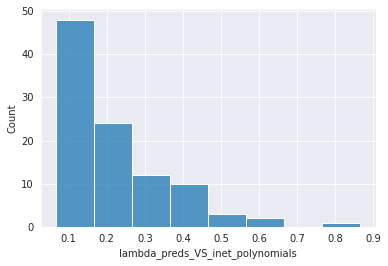

In [41]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


[(0.0, 1.0)]

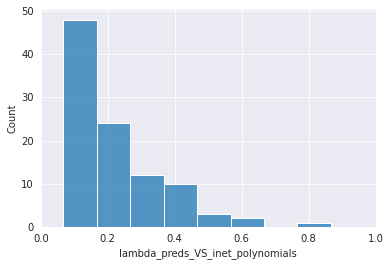

In [42]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


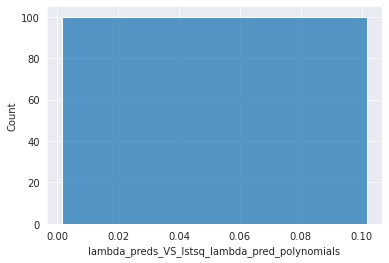

In [43]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


[(0.0, 1.0)]

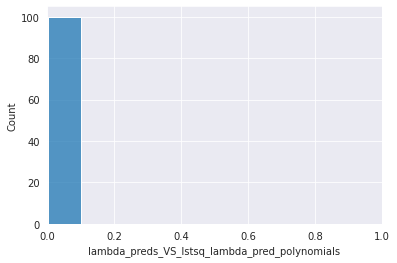

In [44]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


In [45]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/metric_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


In [46]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/loss_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

In [47]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [48]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [49]:
if len(scores_test_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

In [50]:
index = 6

custom_representation_keys_fixed = ['target_polynomials', 'lstsq_target_polynomials', 'lstsq_lambda_pred_polynomials', 'lstsq_lambda_pred_polynomials']
custom_representation_keys_dynamic = ['inet_polynomials', 'per_network_polynomials']
sympy_representation_keys = ['metamodel_functions']


print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')

for key in polynomial_dict_test_list[-1].keys():
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print(key)
    if key in custom_representation_keys_fixed:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], force_complete_poly_representation=True, round_digits=4)
    elif key in custom_representation_keys_dynamic:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], round_digits=4)
    else:
        display(polynomial_dict_test_list[-1][key][index])

print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
lstsq_lambda_pred_polynomials


-0.0005*a**2 - 0.0021*a*b + 0.7496*a*c + 0.2262*a*d - 0.0003*a*e + 0.0061*a - 0.0091*b**2 - 0.372*b*c - 0.0076*b*d + 0.0006*b*e + 0.0119*b - 0.0055*c**2 + 0.0019*c*d + 0.0091*c*e + 0.1964*c - 0.0124*d**2 - 0.0013*d*e + 0.0134*d + 0.0051*e**2 - 0.1443*e - 0.0017

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
lstsq_target_polynomials


0.7588*a*c + 0.229*a*d - 0.3796*b*c + 0.1988*c - 0.1354*e

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
target_polynomials


0.7588*a*c + 0.229*a*d - 0.3796*b*c + 0.1988*c - 0.1354*e

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
inet_polynomials


-0.116400003433228*b*c + 1.15479996800423*b*d + 0.0423000007867813

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
symbolic_regression_functions


X2*(X0 - 0.133)

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


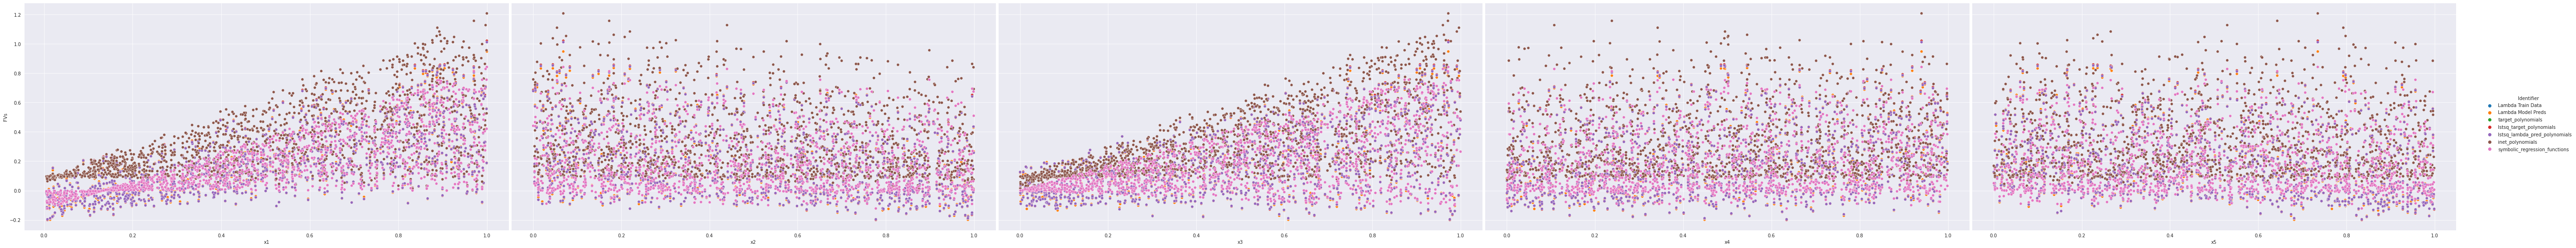

In [51]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=1)

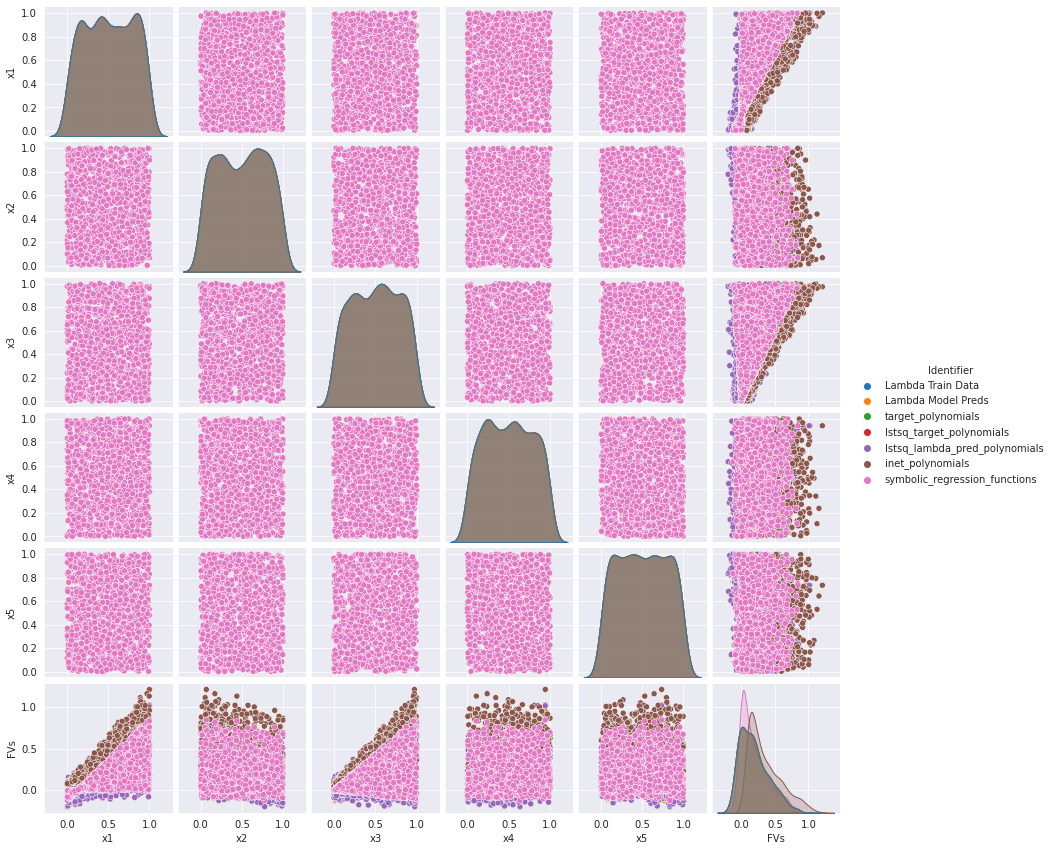

In [52]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=2)

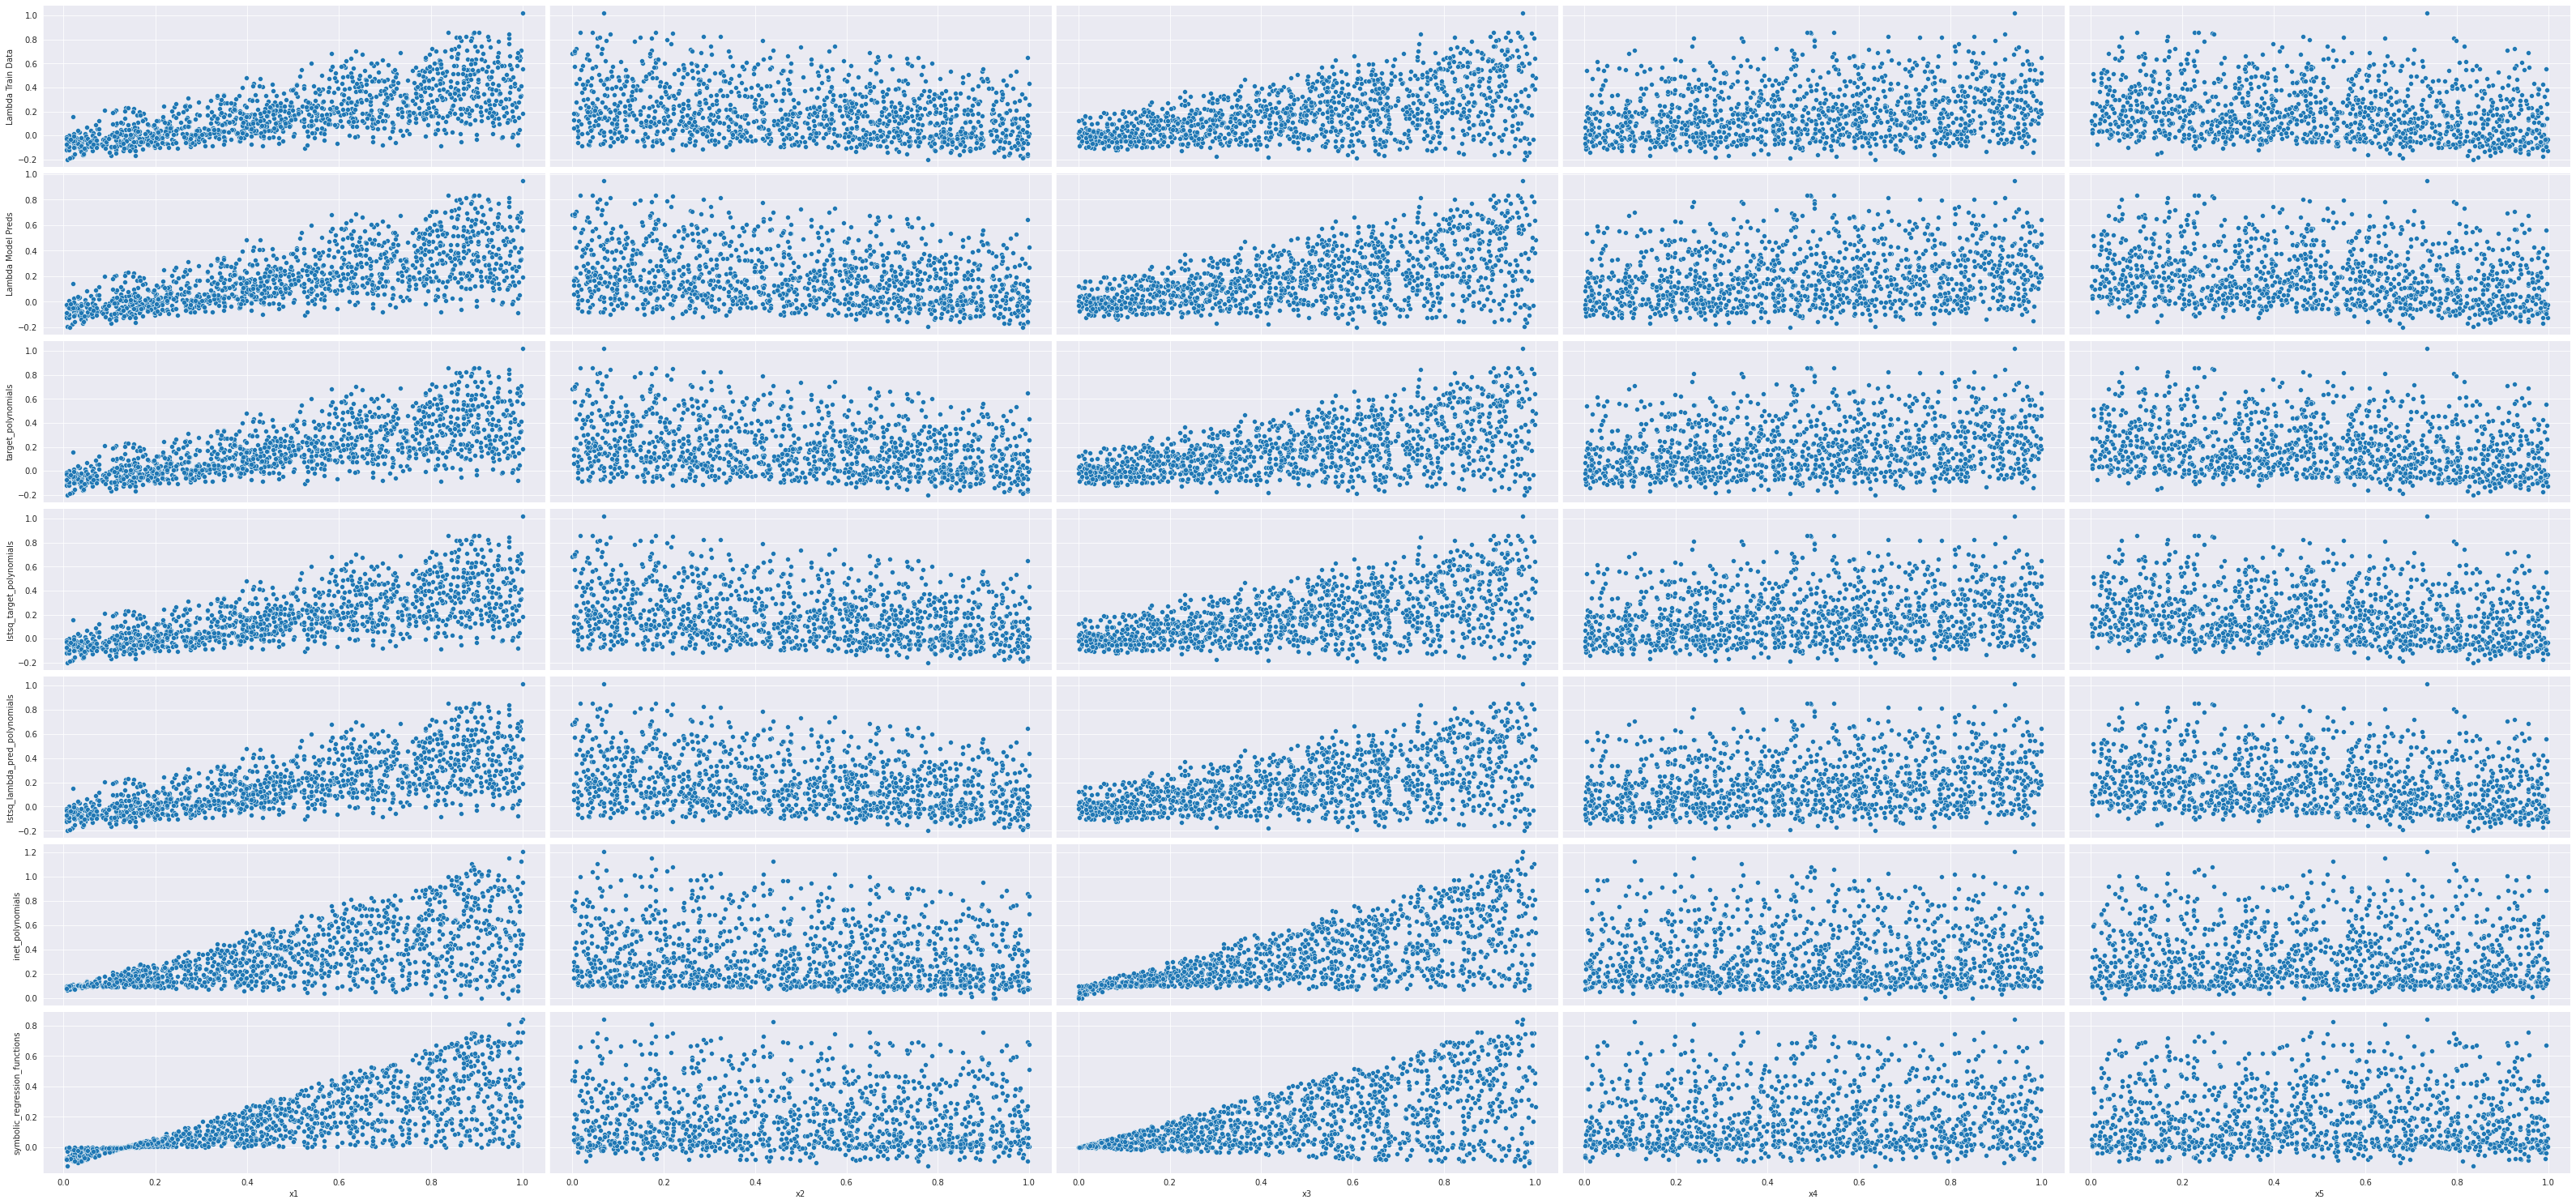

In [53]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=3)

# BENCHMARK (RANDOM GUESS) EVALUATION

In [54]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [55]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

True
True


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.1s finished


In [56]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

Random Guess Error Coefficients: 4.9896


In [57]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

Random Guess Error FVs: 9.8184


# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [58]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

True


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.1s finished


In [59]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

Educated Guess/Mean Prediction Error FVs: 0.5073


In [60]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [61]:
lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
current_jobs = 1

lr=0.5
max_steps = 100
early_stopping=10
restarts=2
per_network_dataset_size = 500

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

if n_jobs != -1:
    n_jobs_per_network = min(n_jobs, os.cpu_count() // current_jobs)
else: 
    n_jobs_per_network = os.cpu_count() // current_jobs - 1

printing = True if n_jobs_per_network == 1 else False


lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
if evaluate_with_real_function: #target polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.target_polynomial_list)
else: #lstsq lambda pred polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list)


config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }


lambda_network_weights = lambda_network_weights_list[0]
poly_representation = poly_representation_list[0]



per_network_poly_optimization_tf(per_network_dataset_size, 
                                lambda_network_weights, 
                                  list_of_monomial_identifiers_numbers, 
                                  config, 
                                  lr=lr, 
                                  max_steps = max_steps, 
                                  early_stopping=early_stopping, 
                                  restarts=restarts, 
                                  printing=True)


NEW


ValueError: in user code:

    ../utilities/utility_functions.py:1332 function_to_optimize  *
        poly_optimize_identifiers_list = tf.keras.backend.flatten(poly_optimize_identifiers_list)
    /home/smarton/anaconda3/envs/xai/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper  **
        return target(*args, **kwargs)
    /home/smarton/anaconda3/envs/xai/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:3338 flatten
        return array_ops.reshape(x, [-1])
    /home/smarton/anaconda3/envs/xai/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/smarton/anaconda3/envs/xai/lib/python3.8/site-packages/tensorflow/python/ops/array_ops.py:195 reshape
        result = gen_array_ops.reshape(tensor, shape, name)
    /home/smarton/anaconda3/envs/xai/lib/python3.8/site-packages/tensorflow/python/ops/gen_array_ops.py:8377 reshape
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /home/smarton/anaconda3/envs/xai/lib/python3.8/site-packages/tensorflow/python/framework/op_def_library.py:538 _apply_op_helper
        raise ValueError(

    ValueError: Tried to convert 'tensor' to a tensor and failed. Error: Dimension 0 in both shapes must be equal, but are 15 and 0. Shapes are [15] and [0].
    	From merging shape 21 with other shapes. for '{{node Reshape/packed}} = Pack[N=25, T=DT_FLOAT, axis=0](Softmax, Softmax_1, Softmax_2, Softmax_3, Softmax_4, Softmax_5, Softmax_6, Softmax_7, Softmax_8, Softmax_9, Softmax_10, Softmax_11, Softmax_12, Softmax_13, Softmax_14, Softmax_15, Softmax_16, Softmax_17, Softmax_18, Softmax_19, Softmax_20, Softmax_21, Softmax_22, Softmax_23, Softmax_24)' with input shapes: [0], [15], [30], [45], [60], [0], [15], [30], [30], [15], [0], [15], [15], [0], [0], [0], [15], [0], [0], [0], [0], [15], [0], [0], [0].


# Evaluate Real Dataset


##  Auto MPG-Dataset

In [ ]:
interpretation_possible_autoMPG = False
print_head_autoMPG = None

url_autoMPG = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names_autoMPG = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset_autoMPG = pd.read_csv(url_autoMPG, names=column_names_autoMPG,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset_autoMPG = raw_dataset_autoMPG.dropna()

dataset_autoMPG['Origin'] = dataset_autoMPG['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset_autoMPG = pd.get_dummies(dataset_autoMPG, columns=['Origin'], prefix='', prefix_sep='')


features_autoMPG = dataset_autoMPG.copy()

labels_autoMPG = features_autoMPG.pop('MPG')

features_autoMPG_normalized = (features_autoMPG-features_autoMPG.min())/(features_autoMPG.max()-features_autoMPG.min())

#labels_autoMPG = (labels_autoMPG-labels_autoMPG.min())/(labels_autoMPG.max()-labels_autoMPG.min())


if features_autoMPG_normalized.shape[1] >= n:
    if n == 1:
        features_autoMPG_model = features_autoMPG_normalized[['Horsepower']]
    elif n == features_autoMPG_normalized.shape[1]:
        features_autoMPG_model = features_autoMPG_normalized
    else:
        features_autoMPG_model = features_autoMPG_normalized.sample(n=n, axis='columns')
        
    print_head_autoMPG = features_autoMPG_model.head()
    interpretation_possible_autoMPG = True

print_head_autoMPG

In [ ]:
#%load_ext autoreload

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    ((lambda_index_autoMPG, 
     current_seed_autoMPG, 
     polynomial_autoMPG, 
     polynomial_lstsq_pred_list_autoMPG, 
     polynomial_lstsq_true_list_autoMPG), 
    scores_list_autoMPG, 
    pred_list_autoMPG, 
    history_autoMPG, 
    model_autoMPG) = train_nn(lambda_index=0, 
                              X_data_lambda=features_autoMPG_model.values, 
                              y_data_real_lambda=labels_autoMPG.values, 
                              polynomial=None, 
                              seed_list=[RANDOM_SEED], 
                              callbacks=[PlotLossesKerasTF()], 
                              return_history=True, 
                              each_epochs_save=None, 
                              printing=False, 
                              return_model=True)
    
    polynomial_lstsq_pred_autoMPG = polynomial_lstsq_pred_list_autoMPG[-1]

In [ ]:
if interpretation_possible_autoMPG and n==1:
    x = tf.linspace(0.0, 250, 251)
    y = model_autoMPG.predict(x)

    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [ ]:
config = {
        'n': n,
        'd': d,
        'inet_loss': inet_loss,
        'sparsity': sparsity,
        'lambda_network_layers': lambda_network_layers,
        'interpretation_net_output_shape': interpretation_net_output_shape,
        'RANDOM_SEED': RANDOM_SEED,
        'nas': nas,
        'number_of_lambda_weights': number_of_lambda_weights,
        'interpretation_net_output_monomials': interpretation_net_output_monomials,
        'fixed_initialization_lambda_training': fixed_initialization_lambda_training,
        'dropout': dropout,
        'lambda_network_layers': lambda_network_layers,
        'optimizer_lambda': optimizer_lambda,
        'loss_lambda': loss_lambda,        
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }

weights_autoMPG = model_autoMPG.get_weights()

weights_flat_autoMPG = []
for layer_weights, biases in pairwise(weights_autoMPG):    #clf.get_weights()
    for neuron in layer_weights:
        for weight in neuron:
            weights_flat_autoMPG.append(weight)
    for bias in biases:
        weights_flat_autoMPG.append(bias)
        
weights_flat_autoMPG = np.array(weights_flat_autoMPG)


x = pred_list_autoMPG['X_test_lambda']
y = pred_list_autoMPG['y_test_real_lambda']

y_model_autoMPG = model_autoMPG.predict(x)




In [ ]:
if interpretation_possible_autoMPG:
    y_polynomial_lstsq_pred_autoMPG = calculate_function_values_from_polynomial(polynomial_lstsq_pred_autoMPG, x, force_complete_poly_representation=True)

    mae_model_polynomial_lstsq_pred_autoMPGy = mean_absolute_error(y_model_autoMPG, y_polynomial_lstsq_pred_autoMPG)
    mae_data_polynomial_lstsq_pred_autoMPG = mean_absolute_error(y, y_polynomial_lstsq_pred_autoMPG)

    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQt Poly:')
    print_polynomial_from_coefficients(y_polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('MAE Model: ', mae_model_polynomial_lstsq_pred_autoMPGy)
    print('MAE Data: ', mae_data_polynomial_lstsq_pred_autoMPG)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    interpretation_net = model_list[-1]
    
    start = time.time() 
    
    #interpretation_net_poly = interpretation_net.predict(np.array([weights_flat_autoMPG]))[0]
    interpretation_net_poly = make_inet_prediction(interpretation_net, weights_flat_autoMPG, network_data=None, lambda_trained_normalized=False, inet_training_normalized=normalize_inet_data, normalization_parameter_dict=None)
    
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_interpretation_net_poly = calculate_function_values_from_polynomial(interpretation_net_poly, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_interpretation_net_poly)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_interpretation_net_poly)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)    
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG:

    start = time.time() 
    
    if False:
        per_network_hyperparams = {
            'optimizer':  'Powell',
            'jac': 'fprime',
            'max_steps': 5000,#100,
            'restarts': 3,
            'per_network_dataset_size': 500,
        }      
        
        per_network_function =  per_network_poly_optimization_scipy(per_network_dataset_size, 
                                                                  weights_flat_autoMPG, 
                                                                  list_of_monomial_identifiers_numbers, 
                                                                  config, 
                                                                  optimizer = per_network_hyperparams['optimizer'],
                                                                  jac = per_network_hyperparams['jac'],
                                                                  max_steps = per_network_hyperparams['max_steps'], 
                                                                  restarts=per_network_hyperparams['restarts'], 
                                                                  printing=True,
                                                                  return_error=False)
    else:
        per_network_hyperparams = {
            'optimizer': tf.keras.optimizers.RMSprop,
            'lr': 0.02,
            'max_steps': 500,
            'early_stopping': 10,
            'restarts': 3,
            'per_network_dataset_size': 5000,
        }   
        
        per_network_function =  per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                              weights_flat_autoMPG, 
                                                              list_of_monomial_identifiers_numbers, 
                                                              config, 
                                                              optimizer = per_network_hyperparams['optimizer'],
                                                              lr=per_network_hyperparams['lr'], 
                                                              max_steps = per_network_hyperparams['max_steps'], 
                                                              early_stopping=per_network_hyperparams['early_stopping'], 
                                                              restarts=per_network_hyperparams['restarts'], 
                                                              printing=True,
                                                              return_error=False)
            
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)  
    
    y_per_network_function = calculate_function_values_from_polynomial(per_network_function, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_per_network_function)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_per_network_function)    
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)       
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
#%load_ext autoreload

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    
    symbolic_regression_hyperparams = {
        'dataset_size': 500,
    }

    start = time.time() 
    
    symbolic_regression_function =  symbolic_regression(model_autoMPG, 
                                                      config,
                                                      symbolic_regression_hyperparams,
                                                      #printing = True,
                                                      return_error = False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    variable_names = ['X' + str(i) for i in range(n)]
    
    y_symbolic_regression_function = calculate_function_values_from_sympy(symbolic_regression_function, x, variable_names=variable_names)
    
    mae_model_symbolic_regression_function = mean_absolute_error(y_model_autoMPG, y_symbolic_regression_function)
    mae_data_symbolic_regression_function = mean_absolute_error(y, y_symbolic_regression_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Poly:')    
    display(symbolic_regression_function)
    print('MAE Model: ', mae_model_symbolic_regression_function)
    print('MAE Data: ', mae_data_symbolic_regression_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG and True:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = False,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function = calculate_function_values_from_sympy(metamodel_function, x)
    
    mae_model_metamodel_function = mean_absolute_error(y_model_autoMPG, y_metamodel_function)
    mae_data_metamodel_function = mean_absolute_error(y, y_metamodel_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')    
    display(metamodel_function)
    print('MAE Model: ', mae_model_metamodel_function)
    print('MAE Data: ', mae_data_metamodel_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG and False:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function_basic =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = True,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function_basic = calculate_function_values_from_sympy(metamodel_function_basic, x)
    
    mae_metamodel_function_basic = mean_absolute_error(y_model_autoMPG, y_metamodel_function_basic)
    mae_metamodel_function_basic = mean_absolute_error(y, y_metamodel_function_basic)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function Basic:')    
    display(metamodel_function_basic)
    print('MAE Model: ', mae_metamodel_function_basic)
    print('MAE Data: ', mae_metamodel_function_basic)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG:
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQ Poly:')
    print_polynomial_from_coefficients(polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Function:')
    display(symbolic_regression_function)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')
    display(metamodel_function)
    #print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    #print('Metamodel Function Basic:')
    #display(metamodel_function_basic)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
if interpretation_possible_autoMPG and n==1:
    fig, ax = plt.subplots(1, 1, figsize=(20,10))
    
    ax.set_ylim([0,50])
    
    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.scatter(x, y, label='Test Data')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_model_autoMPG))]) , label='Model Predictions')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_interpretation_net_poly))]) , label='Interpretation Net Poly')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_per_network_function))]) , label='Per Network Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_polynomial_lstsq_pred_autoMPG))]) , label='LSTSQ Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_symbolic_regression_function))]) , label='Symbolic Regression Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_metamodel_function))]) , label='Metamodel Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y))]) y_metamodel_function_basic, label='Metamodel Function Basic')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [ ]:
sample_data_X = np.array([i for i in range(1000)])
sample_data_y = np.array([3*i for i in range(1000)])

current_seed = 42

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y*1000,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y+1000,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:


model_2_weights = model.get_weights()
model_2_normalized_weights = model_2_weights #[weights/10 for weights in model_2_weights]


model_2_normalized_weights[-6] = model_2_normalized_weights[-6]/10
model_2_normalized_weights[-5] = model_2_normalized_weights[-5]/10

model_2_normalized_weights[-4] = model_2_normalized_weights[-4]/10
model_2_normalized_weights[-3] = model_2_normalized_weights[-3]/100

model_2_normalized_weights[-2] = model_2_normalized_weights[-2]/10
model_2_normalized_weights[-1] = model_2_normalized_weights[-1]/1000

model_2.set_weights(model_2_normalized_weights)

print(model_2.get_weights())
print(model_2.predict([1, 10]))

# Evaluate Per-Network Poly Optimization

## Example Optimization (Common Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer':  'Powell',
    'jac': 'fprime',
    'max_steps': 5000,#100,
    'restarts': 3,
    'per_network_dataset_size': 500,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_scipy(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      jac = per_network_hyperparams['jac'],
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Example Optimization (Neural Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer': tf.keras.optimizers.RMSprop,
    'lr': 0.02,
    'max_steps': 500,
    'early_stopping': 10,
    'restarts': 3,
    'per_network_dataset_size': 5000,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      lr = per_network_hyperparams['lr'], 
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      early_stopping = per_network_hyperparams['early_stopping'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error.numpy()))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Grid Search Common Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 10

per_network_hyperparams = {
    'optimizer':  [
                   'Nelder-Mead', 
                   'Powell', 
        
                   'CG',
                   'BFGS',
                   'Newton-CG', 
                   #'L-BFGS-B', #'>' not supported between instances of 'int' and 'NoneType'
                   'TNC', 
                   
                   'COBYLA', 
                   'SLSQP', 
                   
                   #'trust-constr', # TypeError: _minimize_trustregion_constr() got an unexpected keyword argument 'maxfun'
                   #'dogleg', # ValueError: Hessian is required for dogleg minimization
                   #'trust-ncg', #ValueError: Either the Hessian or the Hessian-vector product is required for Newton-CG trust-region minimization
                   #'trust-exact', # ValueError: Hessian matrix is required for trust region exact minimization.
                   #'trust-krylov' #ValueError: Either the Hessian or the Hessian-vector product is required for Krylov trust-region minimization
                   ], 
    'jac': ['fprime'],
    'max_steps': [5000],#100,
    'restarts': [3],
    'per_network_dataset_size': [500],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_scipy)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  jac = params['jac'],
                                                                                  max_steps = params['max_steps'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

## Grid Search Neural Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 100

per_network_hyperparams = {
    'optimizer': [tf.keras.optimizers.RMSprop], #[tf.keras.optimizers.SGD, tf.optimizers.Adam, tf.keras.optimizers.RMSprop, tf.keras.optimizers.Adadelta]
    'lr': [0.02], #[0.5, 0.25, 0.1, 0.05, 0.025]
    'max_steps': [5000],#100,
    'early_stopping': [10],
    'restarts': [3],
    'per_network_dataset_size': [5000],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_tf)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  lr = params['lr'], 
                                                                                  max_steps = params['max_steps'], 
                                                                                  early_stopping = params['early_stopping'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

In [ ]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()